In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from pathlib import Path
from sklearn.ensemble import ExtraTreesRegressor

from sklearn import metrics

In [2]:
PATH = Path('./data/bluebook/')

# Lesson 3

## 00:00:00 - Lesson 2 recap

* Common refrain = things like Random Forests hide meaning from us - not the case: can understand data deeper and quicker.
* Going to look at larger datasets.

## 00:02:32 - Audience questions

* Q1: When should I use Random Forests?
* A1: Almost always for structured data: good starting point.
  * Deep learning for unstructured data.

## 00:04:42 - proc_df function bug

* `proc_df` didn't have a way to reuse the missing data values in the test set.
  * Now returns `nas` as a third return elemnt in the tuple

In [4]:
df_raw = pd.read_csv(f'{PATH}/Train.csv', low_memory=False, parse_dates=['saledate'])
add_datepart(df_raw, 'saledate')
train_cats(df_raw)

In [5]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')

In [6]:
na_dict

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

## 00:09:25 - Bigger datasets and Groceries competition

* Ability to explain problem key to machine learning.
* Favorita Grocery Sales Forecasting:
  * Goal: Predict how much stock would be sold on each day for each item during a 2 week period.
  * Data provided:
    * how many units of each product on each sold was sold in the last year.
    * Metadata for store (location, class of store)
    * Metadata for each product (category of product)
    * Metadata for each data (oil price on the date)

* "Relational dataset" - number of things you can join together.
* Star schema:
  * Central transactions table `train.csv`
    * Includes `unit_sales` by `date`, `store_nbr` and `item_nbr`
  * Can join metadata to central table.
* Snowflake schema:
  * Tables join other tables.

In [7]:
PATH = Path('./data/grocery-sales')

In [8]:
!kaggle competitions download -c favorita-grocery-sales-forecasting --path {PATH}

test.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
stores.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
oil.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
items.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
holidays_events.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
transactions.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
train.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.7z: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
for file in PATH.iterdir():
    if not str(file).endswith('7z'):
        continue

    !7z x {file} -o{PATH} -aoa > /dev/null

In [10]:
!mkdir -p {PATH}/tmp

### 00:15:14 - `limit_memory` in `read_csv`

* Set `limit_memory=False` will run out of memory on big datasets.
  * Instead, want to tell Pandas what the dataframe types are by passing a `dtype` argument to `read_csv`.  

In [11]:
types = {
    'id': 'int64', 'item_nbr': 'int32', 'store_nbr': 'int8',
    'unit_sales': 'float32', 'onpromotion': 'object'
}

In [12]:
%%time
df_all = pd.read_csv(
    PATH / 'train.csv', parse_dates=['date'], dtype=types,
    infer_datetime_format=True
)

CPU times: user 1min 52s, sys: 7.83 s, total: 1min 59s
Wall time: 2min


In [13]:
df_all.onpromotion.fillna(False, inplace=True)
df_all.onpromotion = df_all.onpromotion.map({'False': False, 'True': True})
df_all.onpromotion = df_all.onpromotion.astype(bool)

%time df_all.to_feather(PATH / 'tmp/raw_groceries')

CPU times: user 1.82 s, sys: 3.59 s, total: 5.4 s
Wall time: 4.21 s


In [14]:
%time df_all.describe(include='all')

CPU times: user 35.8 s, sys: 9.41 s, total: 45.3 s
Wall time: 45.5 s


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
count,1.254970e+08,125497040,1.254970e+08,1.254970e+08,1.254970e+08,125497040
unique,NaN,1684,NaN,NaN,NaN,2
top,NaN,2017-07-01 00:00:00,NaN,NaN,NaN,False
freq,NaN,118194,NaN,NaN,NaN,96028767
first,NaN,2013-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2017-08-15 00:00:00,NaN,NaN,NaN,NaN
mean,6.274852e+07,NaN,2.746458e+01,9.727692e+05,8.554856e+00,NaN
std,3.622788e+07,NaN,1.633051e+01,5.205336e+05,2.360515e+01,NaN
min,0.000000e+00,NaN,1.000000e+00,9.699500e+04,-1.537200e+04,NaN
25%,3.137426e+07,NaN,1.200000e+01,5.223830e+05,2.000000e+00,NaN


### 00:20:30 - `shuf` command

* [`shuf`](https://shapeshed.com/unix-shuf/) can be used to read in a random sample of a file.

In [15]:
%time df_all = pd.read_feather(PATH / 'tmp/raw_groceries')

CPU times: user 1.94 s, sys: 4.55 s, total: 6.49 s
Wall time: 14.5 s


### 00:23:15 - Overlapping dates in training and test set

* Want to ensure dates in training and test set don't overlap.
* If you are using a sample of the training dataset, don't get random rows: get the most recent dates (or some range).

Need to set the log of the dependant to match the Kaggle eval criteria.

In [16]:
df_test = pd.read_csv(PATH / 'test.csv')

In [17]:
df_all.unit_sales = np.log1p(np.clip(df_all.unit_sales, 0, None))

In [18]:
%time add_datepart(df_all, 'date')

CPU times: user 1min 21s, sys: 43.2 s, total: 2min 4s
Wall time: 2min 11s


In [19]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [20]:
n_valid = len(df_test)
n_trn = len(df_all) - n_valid
train, valid = split_vals(df_all, n_trn)
train.shape, valid.shape

((122126576, 18), (3370464, 18))

In [21]:
%%time
trn, y, nas = proc_df(train, 'unit_sales')
val, y_val, _ = proc_df(valid, 'unit_sales', nas)

CPU times: user 1min 4s, sys: 1min 38s, total: 2min 42s
Wall time: 3min


### 00:28:10 - set `rf_samples`

* Data set size is 120m records: probably don't want to create a tree from that.
* Since a random forest size is determined by number of estimators * sample size, you can use `set_rf_samples(1_000_000)` to reduce the sample size per estimate.

In [22]:
def rmse(x, y):
    return math.sqrt( ((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(x), y), rmse(m.predict(val), y_val),
                m.score(x, y), m.score(x, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [23]:
set_rf_samples(1_000_000)

### 00:29:40 - why set `n_jobs`?

* Q1: Why is `n_jobs` not -1.
* A1: Number of jobs is number of cores. J had 60 cores on a machine and found it slower to use all cores

### 00:30:11 - `%prun`

* Jeremy learned that the random forest was calling this line:

In [24]:
%time x = np.array(trn, dtype=np.float32)

CPU times: user 2min 24s, sys: 3min 3s, total: 5min 27s
Wall time: 6min 9s


  so he pulled it out and ran it himself.
* He found that using the profiler: `%prun`.

In [25]:
m = RandomForestRegressor(n_estimators=20, min_samples_leaf=100, n_jobs=8)

In [26]:
%prun m.fit(x, y)

```
40010 function calls (39760 primitive calls) in 291.961 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       90  281.232    3.125  281.232    3.125 {method 'acquire' of '_thread.lock' objects}
        2   10.016    5.008   10.016    5.008 {method 'reduce' of 'numpy.ufunc' objects}
        8    0.472    0.059    0.472    0.059 {built-in method numpy.core.multiarray.array}
        1    0.094    0.094  291.960  291.960 <string>:1(<module>)
        2    0.010    0.005    0.010    0.005 {built-in method marshal.loads}
       21    0.007    0.000    0.008    0.000 validation.py:617(check_random_state)
        1    0.006    0.006    0.099    0.099 _parallel_backends.py:132(terminate)
        5    0.005    0.001    0.005    0.001 {built-in method builtins.__build_class__}
        1    0.005    0.005  281.317  281.317 parallel.py:742(__call__)
        1    0.004    0.004  281.166  281.166 parallel.py:684(retrieve)
        2    0.004    0.002   10.022    5.011 validation.py:33(_assert_all_finite)
        1    0.004    0.004    0.036    0.036 pool.py:153(__init__)
      100    0.004    0.000    0.023    0.000 base.py:213(get_params)
        1    0.004    0.004  291.865  291.865 forest.py:220(fit)
       20    0.004    0.000    0.004    0.000 {method 'randint' of 'mtrand.RandomState' objects}
        1    0.004    0.004    0.005    0.005 pool.py:531(close)
        1    0.003    0.003    0.006    0.006 parallel.py:473(__init__)
     1128    0.003    0.000    0.003    0.000 {built-in method builtins.hasattr}
```

In [27]:
print(f'RMSE train: {rmse(m.predict(x), y)}')
print(f'RMSE val: {rmse(m.predict(val), y_val)}')
print(f'R^2 val: {m.score(val, y_val)}')

RMSE train: 0.7742444081877221
RMSE val: 0.7672266305399347
R^2 val: 0.21656830827996176


In [28]:
preds_model_1 = m.predict(x)

### 00:33:30 - On the Kaggle leaderboard

* Random forests don't work that well on the data.
* Someone on Kaggle found you just take the last 2 weeks and take the average sales by `store_nbr`, `item_nbr`, `onpromotion` and puts you in the top 30.

### 00:39:08 - Errors in ML

* Machine learning can be very frustrating because errors can be silent: the performance on the model can be slightly worse, you don't know if it's a bug or a limitation as the data.
* One idea: create a scatterplot of predictions from one predictions on one model and predictions from another on another axis. Should be a straight line.

In [29]:
m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, n_jobs=8)
m.fit(x, y)
preds_model_2 = m.predict(x)

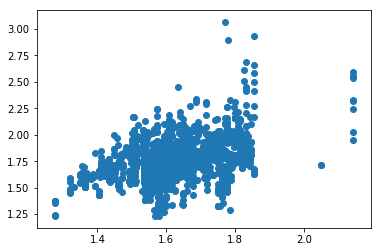

In [34]:
plt.scatter(preds_model_1[:2000], preds_model_2[:2000])
plt.show()

### 00:41:16 - Audience questions

* Q1: When should you use external data (like weather etc)?
* A1: Very often. On Kaggle, you have to provide the data you used on the forum (if competition allows it).

### 00:44:39 - Calibrating validation set